In [1]:
# ------------------------------
# 📦 Imports
# ------------------------------
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

from scipy.stats import skew, kurtosis
from scipy.signal import welch

import neurokit2 as nk
import antropy as ant
import traceback

# Hugging Face dataset loader (for Dreaddit)
from datasets import load_dataset

# TensorFlow for FER-2013 images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


C:\Users\chira\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================================
# 🚀 AUTO-LOAD PRETRAINED MODELS AND PROBABILITIES (Restart-Safe)
# ============================================================

import os, pickle

model_files = {
    "ecg": "ecg_model.pkl",
    "text": "text_model.pkl",
    "face": "face_model.pkl",
    "voice": "voice_model.pkl",
    "fusion": "fusion_inputs.pkl"
}

loaded_ok = []
for name, file in model_files.items():
    if os.path.exists(file):
        try:
            data = pickle.load(open(file, "rb"))
            # Handle both dict or model-only pickle structures
            if isinstance(data, dict):
                globals().update(data)
            else:
                globals()[f"{name}_model"] = data
            loaded_ok.append(name)
        except Exception as e:
            print(f"⚠️ Error loading {name} model → {e}")
    else:
        print(f"⚠️ {file} not found, will retrain {name} model.")

if loaded_ok:
    print(f"✅ Successfully loaded pretrained models: {', '.join(loaded_ok)}")
else:
    print("⚠️ No models found — all will be trained fresh.")


⚠️ ecg_model.pkl not found, will retrain ecg model.
⚠️ text_model.pkl not found, will retrain text model.
⚠️ face_model.pkl not found, will retrain face model.
⚠️ voice_model.pkl not found, will retrain voice model.
⚠️ fusion_inputs.pkl not found, will retrain fusion model.
⚠️ No models found — all will be trained fresh.


In [3]:
# ----------------------
# 💡 ECG Feature Extraction
# ----------------------
def extract_ecg_features(segment, fs=700):  # WESAD chest ECG = 700 Hz
    if len(segment) == 0:
        return None
    try:
        features = [
            np.mean(segment), np.std(segment), np.min(segment), np.max(segment),
            np.percentile(segment, 25), np.percentile(segment, 75),
            np.median(segment), skew(segment), kurtosis(segment)
        ]

        # HRV
        try:
            _, rpeaks = nk.ecg_peaks(segment, sampling_rate=fs)
            rr_intervals = np.diff(rpeaks["ECG_R_Peaks"]) / fs
            if len(rr_intervals) > 2:
                features.extend([
                    np.mean(rr_intervals), np.std(rr_intervals),
                    np.sqrt(np.mean(np.square(np.diff(rr_intervals)))),
                    np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals)
                ])
            else: features.extend([0,0,0,0])
        except: features.extend([0,0,0,0])

        # Frequency
        try:
            if len(rr_intervals) > 4:
                f, pxx = welch(rr_intervals, fs=4.0, nperseg=min(256, len(rr_intervals)))
                vlf = np.trapz(pxx[(f >= 0.003) & (f < 0.04)])
                lf = np.trapz(pxx[(f >= 0.04) & (f < 0.15)])
                hf = np.trapz(pxx[(f >= 0.15) & (f < 0.4)])
                lf_hf = lf / hf if hf > 0 else 0
                features.extend([vlf, lf, hf, lf_hf])
            else: features.extend([0,0,0,0])
        except: features.extend([0,0,0,0])

        # Entropy
        try: features.append(ant.sample_entropy(segment))
        except: features.append(0)

        return features
    except:
        return None




# ----------------------
# 📥 Load WESAD ECG Dataset (fixed label mapping)
# ----------------------
X_ecg, y_ecg = [], []
window_size = 256
data_path = r"C:\Users\chira\OneDrive\Desktop\ECG BASED STRESS AND EMOTION DETECTION\WESAD"

for subject_id in range(2, 18):
    folder = os.path.join(data_path, f"S{subject_id}")
    pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
    if not pkl_files:
        continue

    with open(pkl_files[0], "rb") as f:
        data = pickle.load(f, encoding="latin1")
        ecg = np.array(data['signal']['chest']['ECG'])[:, 0]
        labels = np.array(data['label'])

    # Debug: check label distribution per subject
    print(f"Subject {subject_id} labels:", np.unique(labels, return_counts=True))

    for i in range(0, len(ecg) - window_size, window_size):
        segment = ecg[i:i+window_size]
        label = labels[i + window_size//2]

        # Map to binary: Stress (2) → 1, all others (1,3,4,5,6,7) → 0
        if label == 0:  
            continue  # skip unlabeled
        binary_label = 1 if label == 2 else 0

        features = extract_ecg_features(segment)
        if features:
            X_ecg.append(features)
            y_ecg.append(binary_label)

X_ecg, y_ecg = np.array(X_ecg), np.array(y_ecg)
print("✅ ECG dataset:", X_ecg.shape)
print("Class distribution:", Counter(y_ecg))


Subject 2 labels: (array([0, 1, 2, 3, 4, 6, 7], dtype=int32), array([2142701,  800800,  430500,  253400,  537599,   45500,   44800]))
Subject 3 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([2345699,  798000,  448000,  262500,  546001,   51100,   46900,
         46900]))
Subject 4 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([2314199,  810601,  444500,  260400,  563500,   35699,   30800,
         36401]))
Subject 5 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([2142700,  838600,  451500,  261800,  555800,   50401,   30799,
         49000]))
Subject 6 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([2733499,  826000,  455000,  260400,  550900,   40600,   35001,
         48300]))
Subject 7 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1472098,  830200,  448000,  260401,  553001,   35000,   30799,
         37101]))
Subject 8 labels: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1616300,  818300,  469000,  2

In [4]:
print("✅ ECG dataset:", X_ecg.shape)
print("Class distribution:", Counter(y_ecg))


✅ ECG dataset: (129500, 18)
Class distribution: Counter({np.int64(0): 102250, np.int64(1): 27250})


In [5]:
# ----------------------
# 📥 Load Dreaddit Text Dataset
# ----------------------
ds = load_dataset("andreagasparini/dreaddit")
df_text = ds['train'].to_pandas()

y_text = df_text['label'].values
feature_cols = [c for c in df_text.columns if c.startswith("lex_liwc")]
X_text = df_text[feature_cols].values

print("✅ Dreaddit:", X_text.shape, Counter(y_text))


✅ Dreaddit: (2838, 93) Counter({np.int64(1): 1488, np.int64(0): 1350})


In [6]:
# ----------------------
# 📥 Load Full FER-2013 Dataset and Extract Embeddings
# ----------------------
fer_path = r"C:\Users\chira\OneDrive\Desktop\ECG BASED STRESS AND EMOTION DETECTION\FER-2013"
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(fer_path, "train"),
    target_size=(48,48), color_mode="grayscale",
    class_mode="categorical", batch_size=256, shuffle=True
)

# Map emotions → stress
def map_emotion_to_stress(y_emotion):
    stress_classes = [0,1,2,4]   # Angry, Disgust, Fear, Sad
    nonstress_classes = [3,5,6]  # Happy, Surprise, Neutral
    return np.array([1 if np.argmax(y) in stress_classes else 0 for y in y_emotion])

# CNN base for embeddings
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(96,96,3))

def preprocess_faces(images):
    images_rgb = np.repeat(images, 3, axis=-1)         # grayscale → 3 channels
    images_resized = tf.image.resize(images_rgb, (96,96)).numpy()
    return preprocess_input(images_resized)

# Collect embeddings for ALL batches
all_embeddings, all_labels = [], []
for _ in range(len(train_gen)):
    X_batch, y_batch = next(train_gen)
    y_stress_batch = map_emotion_to_stress(y_batch)
    X_pre = preprocess_faces(X_batch)
    emb = base_model.predict(X_pre, verbose=0)
    all_embeddings.append(emb)
    all_labels.append(y_stress_batch)

X_face_embeddings = np.vstack(all_embeddings)
y_face_stress = np.hstack(all_labels)

print("✅ FER-2013 embeddings:", X_face_embeddings.shape)
print("Label distribution:", Counter(y_face_stress))


Found 28709 images belonging to 7 classes.
✅ FER-2013 embeddings: (28709, 1280)
Label distribution: Counter({np.int64(0): 15216, np.int64(1): 13493})


In [7]:
# ============================================================
# 📥 Load & Process RAVDESS Voice Dataset
# ============================================================

import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Path to your audio folder
audio_dir = r"C:\Users\chira\OneDrive\Desktop\ECG BASED STRESS AND EMOTION DETECTION\audio"

# Emotion mapping (from RAVDESS filename format)
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def emotion_to_stress(emotion):
    """Map emotion → stress label"""
    stress_emotions = ["angry", "fearful", "disgust", "sad"]
    return 1 if emotion in stress_emotions else 0

def extract_features(file_path):
    """Extract MFCCs, Chroma, and Spectral Contrast"""
    try:
        y, sr = librosa.load(file_path, sr=16000)
        # Trim silence
        y, _ = librosa.effects.trim(y)

        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)

        return np.hstack([mfccs, chroma, contrast])
    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return None

# Iterate over all audio files
features, labels = [], []

for actor_folder in tqdm(sorted(os.listdir(audio_dir))):
    folder_path = os.path.join(audio_dir, actor_folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if not file.endswith(".wav"):
            continue
        emotion_code = file.split("-")[2]
        if emotion_code not in emotion_map:
            continue
        emotion = emotion_map[emotion_code]
        stress_label = emotion_to_stress(emotion)

        file_path = os.path.join(folder_path, file)
        feat = extract_features(file_path)
        if feat is not None:
            features.append(feat)
            labels.append(stress_label)

X_voice = np.array(features)
y_voice = np.array(labels)

print("✅ Loaded RAVDESS voice dataset")
print("Shape:", X_voice.shape)
print("Label balance:", np.bincount(y_voice))


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:50<00:00,  2.02s/it]

✅ Loaded RAVDESS voice dataset
Shape: (1440, 32)
Label balance: [672 768]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_voice_train, X_voice_test, y_voice_train, y_voice_test = train_test_split(
    X_voice, y_voice, test_size=0.2, random_state=42, stratify=y_voice
)

scaler = StandardScaler()
X_voice_train_scaled = scaler.fit_transform(X_voice_train)
X_voice_test_scaled = scaler.transform(X_voice_test)

print("✅ Train/Test split:", X_voice_train_scaled.shape, X_voice_test_scaled.shape)


✅ Train/Test split: (1152, 32) (288, 32)


In [9]:
# ============================================================
# 🧩 PHASE 2 — Train/Test Split (Updated for RAVDESS Voice Dataset)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import pickle

RANDOM_STATE = 42
TEST_SIZE = 0.2

# ------------------------------
# ECG Dataset
# ------------------------------
X_ecg_train, X_ecg_test, y_ecg_train, y_ecg_test = train_test_split(
    X_ecg, y_ecg, test_size=TEST_SIZE, stratify=y_ecg, random_state=RANDOM_STATE
)
print("ECG:", Counter(y_ecg_train), Counter(y_ecg_test))

# ------------------------------
# Text Dataset (Dreaddit)
# ------------------------------
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    X_text, y_text, test_size=TEST_SIZE, stratify=y_text, random_state=RANDOM_STATE
)
print("Text:", Counter(y_text_train), Counter(y_text_test))

# ------------------------------
# Face Dataset (FER-2013)
# ------------------------------
X_face_train, X_face_test, y_face_train, y_face_test = train_test_split(
    X_face_embeddings, y_face_stress, test_size=TEST_SIZE, stratify=y_face_stress, random_state=RANDOM_STATE
)
print("Face:", Counter(y_face_train), Counter(y_face_test))

# ------------------------------
# Voice Dataset (RAVDESS)
# ------------------------------
X_voice_train, X_voice_test, y_voice_train, y_voice_test = train_test_split(
    X_voice, y_voice, test_size=TEST_SIZE, stratify=y_voice, random_state=RANDOM_STATE
)

scaler_voice = StandardScaler()
X_voice_train_scaled = scaler_voice.fit_transform(X_voice_train)
X_voice_test_scaled = scaler_voice.transform(X_voice_test)

print("Voice:", Counter(y_voice_train), Counter(y_voice_test))

# ============================================================
# 💾 Optional — Save Train/Test Splits for Reuse
# ============================================================

save_data = {
    "X_ecg_train": X_ecg_train, "X_ecg_test": X_ecg_test, "y_ecg_train": y_ecg_train, "y_ecg_test": y_ecg_test,
    "X_text_train": X_text_train, "X_text_test": X_text_test, "y_text_train": y_text_train, "y_text_test": y_text_test,
    "X_face_train": X_face_train, "X_face_test": X_face_test, "y_face_train": y_face_train, "y_face_test": y_face_test,
    "X_voice_train_scaled": X_voice_train_scaled, "X_voice_test_scaled": X_voice_test_scaled,
    "y_voice_train": y_voice_train, "y_voice_test": y_voice_test
}

with open("train_test_splits.pkl", "wb") as f:
    pickle.dump(save_data, f)

print("✅ All modality splits complete and saved to 'train_test_splits.pkl'")


ECG: Counter({np.int64(0): 81800, np.int64(1): 21800}) Counter({np.int64(0): 20450, np.int64(1): 5450})
Text: Counter({np.int64(1): 1190, np.int64(0): 1080}) Counter({np.int64(1): 298, np.int64(0): 270})
Face: Counter({np.int64(0): 12173, np.int64(1): 10794}) Counter({np.int64(0): 3043, np.int64(1): 2699})
Voice: Counter({np.int64(1): 614, np.int64(0): 538}) Counter({np.int64(1): 154, np.int64(0): 134})
✅ All modality splits complete and saved to 'train_test_splits.pkl'


In [10]:
# -----------------------------
# PHASE 3A-1: ECG — Classical ML models
# -----------------------------
import numpy as np
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Optional XGBoost (graceful fallback)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    print("xgboost not available, skipping XGBClassifier. Install via `pip install xgboost` if desired.")
    xgb_available = False



if "rf_ecg" not in globals():
    RND = 42
    X_ecg_train = np.asarray(X_ecg_train)
    X_ecg_test  = np.asarray(X_ecg_test)
    y_ecg_train = np.asarray(y_ecg_train)
    y_ecg_test  = np.asarray(y_ecg_test)

    scaler_ecg = StandardScaler()
    X_ecg_train_scaled = scaler_ecg.fit_transform(X_ecg_train)
    X_ecg_test_scaled  = scaler_ecg.transform(X_ecg_test)

    models_ecg, probs_ecg, preds_ecg, scores_ecg = {}, {}, {}, {}

    # 1) Random Forest
    rf_ecg = RandomForestClassifier(n_estimators=300, random_state=RND, n_jobs=-1)
    rf_ecg.fit(X_ecg_train_scaled, y_ecg_train)
    p_rf = rf_ecg.predict_proba(X_ecg_test_scaled)[:,1]
    y_rf_pred = rf_ecg.predict(X_ecg_test_scaled)
    models_ecg['rf'] = rf_ecg
    probs_ecg['rf'] = p_rf
    preds_ecg['rf'] = y_rf_pred
    scores_ecg['rf'] = {'accuracy': accuracy_score(y_ecg_test, y_rf_pred),
                        'f1': f1_score(y_ecg_test, y_rf_pred)}
    print(f"RF ECG → acc:{scores_ecg['rf']['accuracy']:.4f}, f1:{scores_ecg['rf']['f1']:.4f}")

    # 2) HistGradientBoosting
    hgb_ecg = HistGradientBoostingClassifier(random_state=RND)
    hgb_ecg.fit(X_ecg_train_scaled, y_ecg_train)
    p_hgb = hgb_ecg.predict_proba(X_ecg_test_scaled)[:,1]
    y_hgb_pred = hgb_ecg.predict(X_ecg_test_scaled)
    models_ecg['hgb'] = hgb_ecg
    probs_ecg['hgb'] = p_hgb
    preds_ecg['hgb'] = y_hgb_pred
    scores_ecg['hgb'] = {'accuracy': accuracy_score(y_ecg_test, y_hgb_pred),
                         'f1': f1_score(y_ecg_test, y_hgb_pred)}
    print(f"HGB ECG → acc:{scores_ecg['hgb']['accuracy']:.4f}, f1:{scores_ecg['hgb']['f1']:.4f}")

    # 3) Logistic Regression
    log_ecg = LogisticRegression(max_iter=1000, random_state=RND)
    log_ecg.fit(X_ecg_train_scaled, y_ecg_train)
    p_log = log_ecg.predict_proba(X_ecg_test_scaled)[:,1]
    y_log_pred = log_ecg.predict(X_ecg_test_scaled)
    models_ecg['log'] = log_ecg
    probs_ecg['log'] = p_log
    preds_ecg['log'] = y_log_pred
    scores_ecg['log'] = {'accuracy': accuracy_score(y_ecg_test, y_log_pred),
                         'f1': f1_score(y_ecg_test, y_log_pred)}
    print(f"LogReg ECG → acc:{scores_ecg['log']['accuracy']:.4f}, f1:{scores_ecg['log']['f1']:.4f}")

    # 4) XGBoost (optional)
    if xgb_available:
        xgb_ecg = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)
        xgb_ecg.fit(X_ecg_train_scaled, y_ecg_train)
        p_xgb = xgb_ecg.predict_proba(X_ecg_test_scaled)[:,1]
        y_xgb_pred = xgb_ecg.predict(X_ecg_test_scaled)
        models_ecg['xgb'] = xgb_ecg
        probs_ecg['xgb'] = p_xgb
        preds_ecg['xgb'] = y_xgb_pred
        scores_ecg['xgb'] = {'accuracy': accuracy_score(y_ecg_test, y_xgb_pred),
                             'f1': f1_score(y_ecg_test, y_xgb_pred)}
        print(f"XGB ECG → acc:{scores_ecg['xgb']['accuracy']:.4f}, f1:{scores_ecg['xgb']['f1']:.4f}")

    # Summary + best model
    summary_df = pd.DataFrame(
        [(k,v['accuracy'],v['f1']) for k,v in scores_ecg.items()],
        columns=['model','accuracy','f1']
    ).sort_values('accuracy', ascending=False)
    print("\nECG ML summary:\n", summary_df)

    best_ml_name = max(scores_ecg.items(), key=lambda t: t[1]['f1'])[0]
    best_ml_model_ecg = models_ecg[best_ml_name]
    best_ml_probs_ecg = probs_ecg[best_ml_name]
    print(f"\nSelected ECG model for fusion: {best_ml_name}")
else:
    print("⚡ Classical ECG models already loaded from pickle.")



RF ECG → acc:0.9033, f1:0.7383
HGB ECG → acc:0.8847, f1:0.6828
LogReg ECG → acc:0.8096, f1:0.2779


C:\Users\chira\anaconda3\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [20:07:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB ECG → acc:0.8947, f1:0.7192

ECG ML summary:
   model  accuracy        f1
0    rf  0.903320  0.738349
3   xgb  0.894672  0.719226
1   hgb  0.884749  0.682751
2   log  0.809575  0.277892

Selected ECG model for fusion: rf


In [11]:
# ============================================================
# PHASE 3A-2: ECG — Deep MLP (Keras) and Hybrid Stacking
# ============================================================

# Only train if MLP not already loaded (prevents retraining after restart)
if "ecg_mlp" not in globals():
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression

    print("⚙️ Training Deep MLP + Hybrid Stacking for ECG...")

    # -------------------------
    # 🧠 Build MLP architecture
    # -------------------------
    def build_ecg_mlp(input_dim):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.25),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    ecg_input_dim = X_ecg_train_scaled.shape[1]
    ecg_mlp = build_ecg_mlp(ecg_input_dim)

    # Early stopping
    es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)

    # -------------------------
    # 🚀 Train MLP on ECG features
    # -------------------------
    history = ecg_mlp.fit(
        X_ecg_train_scaled, y_ecg_train,
        validation_split=0.15,
        epochs=100,
        batch_size=256,
        callbacks=[es],
        verbose=0
    )

    # -------------------------
    # 🧾 Evaluate MLP
    # -------------------------
    p_ecg_mlp = ecg_mlp.predict(X_ecg_test_scaled).ravel()
    y_ecg_mlp_pred = (p_ecg_mlp > 0.5).astype(int)

    mlp_acc = accuracy_score(y_ecg_test, y_ecg_mlp_pred)
    mlp_f1  = f1_score(y_ecg_test, y_ecg_mlp_pred)
    mlp_auc = roc_auc_score(y_ecg_test, p_ecg_mlp)

    print(f"✅ ECG MLP → acc: {mlp_acc:.4f}, f1: {mlp_f1:.4f}, auc: {mlp_auc:.4f}")

    # =====================================================
    # 🔁 Hybrid stacking (base model + MLP)
    # =====================================================

    # Internal split for meta training
    X_meta_train_base, X_meta_val, y_meta_train_base, y_meta_val = train_test_split(
        X_ecg_train_scaled, y_ecg_train, test_size=0.2,
        stratify=y_ecg_train, random_state=RND
    )

    # Base classical model (best one from Phase 3A-1)
    best_base = best_ml_model_ecg
    best_base.fit(X_meta_train_base, y_meta_train_base)
    p_base_val = best_base.predict_proba(X_meta_val)[:, 1]

    # Secondary small MLP for stacking
    ecg_mlp_small = build_ecg_mlp(ecg_input_dim)
    ecg_mlp_small.fit(
        X_meta_train_base, y_meta_train_base,
        validation_split=0.1, epochs=50,
        batch_size=128, callbacks=[es], verbose=0
    )
    p_mlp_val = ecg_mlp_small.predict(X_meta_val).ravel()

    # Train meta logistic regression
    meta_X = np.vstack([p_base_val, p_mlp_val]).T
    meta_y = y_meta_val
    meta_clf = LogisticRegression(max_iter=1000)
    meta_clf.fit(meta_X, meta_y)

    # =====================================================
    # 🧪 Evaluate Hybrid on Test Set
    # =====================================================
    p_base_test = best_base.predict_proba(X_ecg_test_scaled)[:, 1]
    p_mlp_test  = p_ecg_mlp  # from full MLP model
    meta_test_X = np.vstack([p_base_test, p_mlp_test]).T

    p_meta_test = meta_clf.predict_proba(meta_test_X)[:, 1]
    y_meta_pred = (p_meta_test > 0.5).astype(int)

    hybrid_acc = accuracy_score(y_ecg_test, y_meta_pred)
    hybrid_f1  = f1_score(y_ecg_test, y_meta_pred)

    print(f"✅ Hybrid (Base + MLP) → acc: {hybrid_acc:.4f}, f1: {hybrid_f1:.4f}")

    # =====================================================
    # 💾 Store Everything for Fusion & Saving
    # =====================================================
    ecg_models_for_fusion = {
        "best_ml_model": best_ml_model_ecg,
        "best_ml_probs_test": best_ml_probs_ecg,   # from Phase 3A-1
        "mlp_model": ecg_mlp,
        "mlp_probs_test": p_ecg_mlp,
        "hybrid_meta_clf": meta_clf,
        "hybrid_probs_test": p_meta_test
    }

    print("✅ ECG modeling finished; objects stored in `ecg_models_for_fusion`.")
else:
    print("⚡ ECG MLP & Hybrid models already loaded from pickle — skipping retraining.")


⚙️ Training Deep MLP + Hybrid Stacking for ECG...
810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ ECG MLP → acc: 0.9029, f1: 0.7424, auc: 0.9380
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Hybrid (Base + MLP) → acc: 0.8995, f1: 0.7343
✅ ECG modeling finished; objects stored in `ecg_models_for_fusion`.


⚡ ECG train/test split already in memory.
⚡ Using existing RandomForest ECG model.
✅ Calibrated RF → Accuracy: 0.9027, AUC: 0.9435


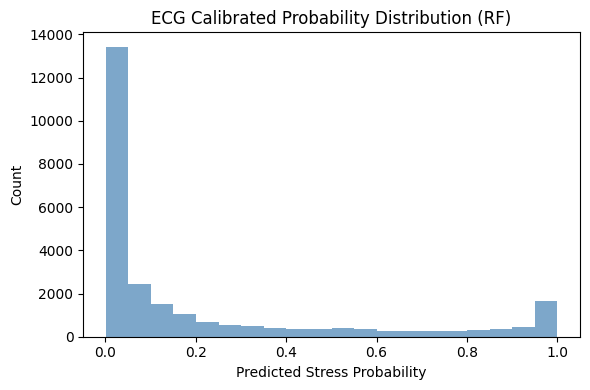

810/810 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
✅ Deep MLP ECG model found and predictions computed.
✅ Selected ECG probability source for fusion: RF (calibrated, more stable)
ECG probability array shape: (25900,)
✅ ECG test probabilities prepared and stored in memory.


In [12]:
# ============================================================
# 🩺 Generate and Calibrate ECG Probabilities for Fusion
# ============================================================
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# ⚙️ Step 1: Ensure train/test split exists
# ------------------------------------------------------------
if not all(name in globals() for name in ["X_ecg_train", "X_ecg_test", "y_ecg_train", "y_ecg_test"]):
    X_ecg_train, X_ecg_test, y_ecg_train, y_ecg_test = train_test_split(
        X_ecg, y_ecg, test_size=0.2, random_state=42, stratify=y_ecg
    )
    print("✅ Created ECG train/test split.")
else:
    print("⚡ ECG train/test split already in memory.")

# ------------------------------------------------------------
# ⚙️ Step 2: Calibrate Random Forest ECG probabilities
# ------------------------------------------------------------
if "rf_ecg" not in globals():
    from sklearn.ensemble import RandomForestClassifier
    rf_ecg = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_ecg.fit(X_ecg_train, y_ecg_train)
    print("⚙️ Trained new RandomForest ECG model for calibration.")
else:
    print("⚡ Using existing RandomForest ECG model.")

# Calibrate model for better probabilistic output
calibrator = CalibratedClassifierCV(rf_ecg, cv=5, method='isotonic')
calibrator.fit(X_ecg_train, y_ecg_train)
ecg_probs_rf = calibrator.predict_proba(X_ecg_test)[:, 1]

# Evaluate RF calibration
rf_acc = accuracy_score(y_ecg_test, calibrator.predict(X_ecg_test))
rf_auc = roc_auc_score(y_ecg_test, ecg_probs_rf)
print(f"✅ Calibrated RF → Accuracy: {rf_acc:.4f}, AUC: {rf_auc:.4f}")

plt.figure(figsize=(6,4))
plt.hist(ecg_probs_rf, bins=20, color='steelblue', alpha=0.7)
plt.title("ECG Calibrated Probability Distribution (RF)")
plt.xlabel("Predicted Stress Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# ⚙️ Step 3: Get Deep MLP ECG probabilities (if available)
# ------------------------------------------------------------
ecg_probs_mlp = None
try:
    if "ecg_mlp" in globals():
        ecg_probs_mlp = ecg_mlp.predict(X_ecg_test).flatten()
        print("✅ Deep MLP ECG model found and predictions computed.")
    else:
        print("⚠️ ECG MLP model not found; skipping MLP probabilities.")
except Exception as e:
    print(f"⚠️ Error during MLP probability computation: {e}")
    ecg_probs_mlp = None

# ------------------------------------------------------------
# ⚙️ Step 4: Choose smoother probability distribution
# ------------------------------------------------------------
if ecg_probs_mlp is not None and (0.05 < np.std(ecg_probs_mlp) < np.std(ecg_probs_rf)):
    ecg_probs_test = ecg_probs_mlp
    selected_source = "MLP (smoother)"
else:
    ecg_probs_test = ecg_probs_rf
    selected_source = "RF (calibrated, more stable)"

print(f"✅ Selected ECG probability source for fusion: {selected_source}")
print(f"ECG probability array shape: {ecg_probs_test.shape}")

# ------------------------------------------------------------
# 💾 Keep key variables ready for saving
# ------------------------------------------------------------
globals().update({
    "ecg_probs_test": ecg_probs_test,
    "y_ecg_test": y_ecg_test
})
print("✅ ECG test probabilities prepared and stored in memory.")


In [13]:
# ============================================================
# 💾 SAVE ALL ECG OBJECTS FOR RESTART SAFETY
# ============================================================
pickle.dump({
    "rf_ecg": rf_ecg if "rf_ecg" in globals() else None,
    "hgb_ecg": hgb_ecg if "hgb_ecg" in globals() else None,
    "log_ecg": log_ecg if "log_ecg" in globals() else None,
    "xgb_ecg": xgb_ecg if "xgb_ecg" in globals() else None,
    "ecg_mlp": ecg_mlp if "ecg_mlp" in globals() else None,
    "meta_clf": meta_clf if "meta_clf" in globals() else None,
    "best_ml_model_ecg": best_ml_model_ecg,
    "best_ml_probs_ecg": best_ml_probs_ecg,
    "ecg_probs_test": ecg_probs_test,
    "y_ecg_test": y_ecg_test
}, open("ecg_model.pkl", "wb"))

print("✅ All ECG models and probabilities saved to ecg_model.pkl successfully.")


✅ All ECG models and probabilities saved to ecg_model.pkl successfully.


In [14]:
# ============================================================
# PHASE 3B-1 — Text (Dreaddit): Classical ML with 5-fold CV
# ============================================================

# Train only if not already loaded from pickle
if "text_ml_model_best" not in globals():
    import numpy as np, pandas as pd
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    from xgboost import XGBClassifier
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    print("⚙️ Training Text (Dreaddit) classical ML models with 5-fold CV...")

    RND = 42
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

    # --------------------------------------------------------
    # ⚙️ Cross-validation helper
    # --------------------------------------------------------
    def crossval_model(clf, X, y, name):
        accs, f1s = [], []
        for fold, (tr, va) in enumerate(kf.split(X, y), 1):
            sc = StandardScaler()
            X_tr, X_va = sc.fit_transform(X[tr]), sc.transform(X[va])
            clf.fit(X_tr, y[tr])
            y_pred = clf.predict(X_va)
            accs.append(accuracy_score(y[va], y_pred))
            f1s.append(f1_score(y[va], y_pred))
            print(f"{name} | Fold {fold}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")
        print(f"→ {name} mean acc={np.mean(accs):.3f}±{np.std(accs):.3f}, "
              f"mean f1={np.mean(f1s):.3f}±{np.std(f1s):.3f}\n")
        return np.mean(accs), np.mean(f1s)

    # --------------------------------------------------------
    # ⚙️ Prepare data
    # --------------------------------------------------------
    X = np.asarray(X_text_train)
    y = np.asarray(y_text_train)

    # --------------------------------------------------------
    # ⚙️ 1) Logistic Regression
    # --------------------------------------------------------
    log_model = LogisticRegression(max_iter=2000, random_state=RND)
    cv_acc_log, cv_f1_log = crossval_model(log_model, X, y, "LogReg")

    # --------------------------------------------------------
    # ⚙️ 2) Random Forest
    # --------------------------------------------------------
    rf_model = RandomForestClassifier(n_estimators=300, random_state=RND, n_jobs=-1)
    cv_acc_rf, cv_f1_rf = crossval_model(rf_model, X, y, "RandomForest")

    # --------------------------------------------------------
    # ⚙️ 3) XGBoost (optional)
    # --------------------------------------------------------
    try:
        xgb_model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss",
            random_state=RND, verbosity=0
        )
        cv_acc_xgb, cv_f1_xgb = crossval_model(xgb_model, X, y, "XGBoost")
    except Exception as e:
        print("⚠️ XGBoost not available, skipping:", e)
        xgb_model, cv_acc_xgb, cv_f1_xgb = None, np.nan, np.nan

    # --------------------------------------------------------
    # ⚙️ Choose best by CV F1
    # --------------------------------------------------------
    scores = {"log": cv_f1_log, "rf": cv_f1_rf, "xgb": cv_f1_xgb}
    best_name = max(scores.items(), key=lambda kv: (0 if np.isnan(kv[1]) else kv[1]))[0]
    print(f"🏆 Best classical text model by mean CV-F1: {best_name}")

    # --------------------------------------------------------
    # ⚙️ Retrain best on full training set
    # --------------------------------------------------------
    sc_text = StandardScaler()
    X_tr_scaled = sc_text.fit_transform(X_text_train)
    X_te_scaled = sc_text.transform(X_text_test)

    if best_name == "rf":   final_clf = rf_model
    elif best_name == "xgb" and xgb_model is not None: final_clf = xgb_model
    else:                   final_clf = log_model

    final_clf.fit(X_tr_scaled, y_text_train)
    y_pred_test = final_clf.predict(X_te_scaled)
    y_prob_test = (final_clf.predict_proba(X_te_scaled)[:, 1]
                   if hasattr(final_clf, "predict_proba") else y_pred_test)

    # --------------------------------------------------------
    # 🧾 Evaluate on test set
    # --------------------------------------------------------
    print("\n📊 Test set report for best classical text model:")
    print(classification_report(y_text_test, y_pred_test))
    print("Confusion Matrix:\n", confusion_matrix(y_text_test, y_pred_test))

    text_ml_probs_test = y_prob_test
    text_ml_model_best = final_clf
    print("✅ Text classical model ready for fusion.")

else:
    print("⚡ Text classical model already loaded from pickle — skipping retraining.")


⚙️ Training Text (Dreaddit) classical ML models with 5-fold CV...
LogReg | Fold 1: acc=0.767, f1=0.785
LogReg | Fold 2: acc=0.767, f1=0.776
LogReg | Fold 3: acc=0.767, f1=0.778
LogReg | Fold 4: acc=0.762, f1=0.776
LogReg | Fold 5: acc=0.758, f1=0.773
→ LogReg mean acc=0.764±0.004, mean f1=0.778±0.004

RandomForest | Fold 1: acc=0.733, f1=0.756
RandomForest | Fold 2: acc=0.744, f1=0.762
RandomForest | Fold 3: acc=0.769, f1=0.781
RandomForest | Fold 4: acc=0.736, f1=0.753
RandomForest | Fold 5: acc=0.767, f1=0.785
→ RandomForest mean acc=0.750±0.015, mean f1=0.767±0.013

XGBoost | Fold 1: acc=0.742, f1=0.762
XGBoost | Fold 2: acc=0.731, f1=0.751
XGBoost | Fold 3: acc=0.733, f1=0.746
XGBoost | Fold 4: acc=0.738, f1=0.751
XGBoost | Fold 5: acc=0.756, f1=0.773
→ XGBoost mean acc=0.740±0.009, mean f1=0.757±0.010

🏆 Best classical text model by mean CV-F1: log

📊 Test set report for best classical text model:
              precision    recall  f1-score   support

           0       0.75      

In [15]:
# ============================================================
# PHASE 3B-2 — Text (Dreaddit): Deep MLP with 5-fold CV
# ============================================================

# Only train if MLP not already loaded (prevents retraining after restart)
if "text_mlp_model" not in globals():
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    from sklearn.model_selection import StratifiedKFold

    RND = 42
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

    print("⚙️ Training Deep MLP for Text (Dreaddit) with 5-fold CV...")

    # ------------------------------------------------------------
    # 🧠 Define model architecture
    # ------------------------------------------------------------
    def build_text_mlp(input_dim):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # ------------------------------------------------------------
    # ⚙️ Cross-validation training
    # ------------------------------------------------------------
    X = np.asarray(X_text_train)
    y = np.asarray(y_text_train)
    input_dim = X.shape[1]

    accs, f1s = [], []
    for fold, (tr, va) in enumerate(kf.split(X, y), 1):
        sc = StandardScaler()
        X_tr, X_va = sc.fit_transform(X[tr]), sc.transform(X[va])
        model = build_text_mlp(input_dim)
        es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
        model.fit(X_tr, y[tr], validation_data=(X_va, y[va]),
                  epochs=30, batch_size=64, callbacks=[es], verbose=0)
        y_pred = (model.predict(X_va).ravel() > 0.5).astype(int)
        acc = accuracy_score(y[va], y_pred)
        f1 = f1_score(y[va], y_pred)
        accs.append(acc)
        f1s.append(f1)
        print(f"Fold {fold}: acc={acc:.3f}, f1={f1:.3f}")

    print(f"\n✅ Text MLP CV → mean acc={np.mean(accs):.3f}±{np.std(accs):.3f}, "
          f"mean f1={np.mean(f1s):.3f}±{np.std(f1s):.3f}")

    # ------------------------------------------------------------
    # 🚀 Retrain on full training set → test
    # ------------------------------------------------------------
    sc_text_mlp = StandardScaler()
    X_tr_scaled = sc_text_mlp.fit_transform(X_text_train)
    X_te_scaled = sc_text_mlp.transform(X_text_test)

    text_mlp_model = build_text_mlp(input_dim)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0)
    text_mlp_model.fit(
        X_tr_scaled, y_text_train,
        validation_split=0.15,
        epochs=50,
        batch_size=64,
        callbacks=[es],
        verbose=0
    )

    # ------------------------------------------------------------
    # 🧾 Evaluate MLP on test set
    # ------------------------------------------------------------
    y_prob_test_mlp = text_mlp_model.predict(X_te_scaled).ravel()
    y_pred_test_mlp = (y_prob_test_mlp > 0.5).astype(int)

    print("\n📊 Test set MLP performance:")
    print(classification_report(y_text_test, y_pred_test_mlp))

    # ------------------------------------------------------------
    # 💾 Store for fusion and saving
    # ------------------------------------------------------------
    text_mlp_probs_test = y_prob_test_mlp

    text_models_for_fusion = {
        "best_ml_model": text_ml_model_best,    # from PHASE 3B-1
        "ml_probs_test": text_ml_probs_test,
        "mlp_model": text_mlp_model,
        "mlp_probs_test": text_mlp_probs_test
    }

    print("✅ Text modeling finished; objects saved to `text_models_for_fusion`.")
else:
    print("⚡ Text MLP model already loaded from pickle — skipping retraining.")


⚙️ Training Deep MLP for Text (Dreaddit) with 5-fold CV...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 1: acc=0.758, f1=0.776
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 2: acc=0.764, f1=0.774
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 3: acc=0.773, f1=0.778
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold 4: acc=0.747, f1=0.752
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 5: acc=0.764, f1=0.780

✅ Text MLP CV → mean acc=0.761±0.009, mean f1=0.772±0.010
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

📊 Test set MLP performance:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       270
           1       0.75      0.77      0.76       298

    accuracy                           0.74       568
   macro avg       0.74      0.74      0.74       568
weighted avg       0.74      0.74      0.74       568

✅ Text modeling finished; objects saved to `text_models_for_fusion`.


In [16]:
# ============================================================
# 💾 SAVE ALL TEXT MODELS AND PROBABILITIES FOR RESTART SAFETY
# ============================================================

import pickle

# Ensure all variables exist before dumping
to_save = {
    "text_ml_model_best": text_ml_model_best if "text_ml_model_best" in globals() else None,
    "text_ml_probs_test": text_ml_probs_test if "text_ml_probs_test" in globals() else None,
    "text_mlp_model": text_mlp_model if "text_mlp_model" in globals() else None,
    "text_mlp_probs_test": text_mlp_probs_test if "text_mlp_probs_test" in globals() else None,
    "y_text_test": y_text_test if "y_text_test" in globals() else None
}

pickle.dump(to_save, open("text_model.pkl", "wb"))

print("✅ All Text models and probabilities saved successfully to 'text_model.pkl'.")
print("Saved keys:", list(to_save.keys()))


✅ All Text models and probabilities saved successfully to 'text_model.pkl'.
Saved keys: ['text_ml_model_best', 'text_ml_probs_test', 'text_mlp_model', 'text_mlp_probs_test', 'y_text_test']


In [17]:
# ============================================================
# PHASE 3C-1 — Face (FER Embeddings): Classical ML with 5-fold CV
# ============================================================

# Train only if not already loaded (prevents retraining after restart)
if "face_ml_model_best" not in globals():
    import numpy as np, pandas as pd
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

    # Optional XGBoost
    try:
        from xgboost import XGBClassifier
        xgb_available = True
    except Exception as e:
        print("⚠️ XGBoost not available, skipping XGBClassifier:", e)
        xgb_available = False

    RND = 42
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

    print("⚙️ Training Face (FER embeddings) classical ML models with 5-fold CV...")

    # ------------------------------------------------------------
    # ⚙️ Cross-validation helper
    # ------------------------------------------------------------
    def crossval_face_model(clf, X, y, name):
        accs, f1s = [], []
        for fold, (tr, va) in enumerate(kf.split(X, y), 1):
            sc = StandardScaler()
            X_tr, X_va = sc.fit_transform(X[tr]), sc.transform(X[va])
            clf.fit(X_tr, y[tr])
            y_pred = clf.predict(X_va)
            accs.append(accuracy_score(y[va], y_pred))
            f1s.append(f1_score(y[va], y_pred))
            print(f"{name} | Fold {fold}: acc={accs[-1]:.3f}, f1={f1s[-1]:.3f}")
        print(f"→ {name} mean acc={np.mean(accs):.3f}±{np.std(accs):.3f}, "
              f"mean f1={np.mean(f1s):.3f}±{np.std(f1s):.3f}\n")
        return np.mean(accs), np.mean(f1s)

    # ------------------------------------------------------------
    # ⚙️ Prepare data
    # ------------------------------------------------------------
    X = np.asarray(X_face_train)
    y = np.asarray(y_face_train)

    # ------------------------------------------------------------
    # ⚙️ 1) Random Forest
    # ------------------------------------------------------------
    rf_face = RandomForestClassifier(n_estimators=300, random_state=RND, n_jobs=-1)
    cv_acc_rf, cv_f1_rf = crossval_face_model(rf_face, X, y, "RandomForest")

    # ------------------------------------------------------------
    # ⚙️ 2) XGBoost (if available)
    # ------------------------------------------------------------
    if xgb_available:
        xgb_face = XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                                 random_state=RND, verbosity=0)
        cv_acc_xgb, cv_f1_xgb = crossval_face_model(xgb_face, X, y, "XGBoost")
    else:
        cv_acc_xgb, cv_f1_xgb = np.nan, np.nan

    # ------------------------------------------------------------
    # 🏆 Choose best model by mean CV F1
    # ------------------------------------------------------------
    best_name = "rf" if (cv_f1_rf >= (cv_f1_xgb if not np.isnan(cv_f1_xgb) else -1)) else "xgb"
    print(f"🏆 Best classical face model by CV F1: {best_name.upper()}")

    # ------------------------------------------------------------
    # 🚀 Train best model on full data → test evaluation
    # ------------------------------------------------------------
    sc_face = StandardScaler()
    X_face_train_scaled = sc_face.fit_transform(X_face_train)
    X_face_test_scaled  = sc_face.transform(X_face_test)

    best_clf = rf_face if best_name == "rf" else xgb_face
    best_clf.fit(X_face_train_scaled, y_face_train)
    y_face_pred = best_clf.predict(X_face_test_scaled)
    y_face_prob = best_clf.predict_proba(X_face_test_scaled)[:, 1]

    print("\n📊 Test set performance for best face classical model:")
    print(classification_report(y_face_test, y_face_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_face_test, y_face_pred))

    # ------------------------------------------------------------
    # 💾 Store for fusion / saving
    # ------------------------------------------------------------
    face_ml_model_best = best_clf
    face_ml_probs_test = y_face_prob

    print("✅ Face classical model ready for fusion.")

else:
    print("⚡ Face classical model already loaded from pickle — skipping retraining.")


⚙️ Training Face (FER embeddings) classical ML models with 5-fold CV...
RandomForest | Fold 1: acc=0.614, f1=0.532
RandomForest | Fold 2: acc=0.605, f1=0.519
RandomForest | Fold 3: acc=0.614, f1=0.527
RandomForest | Fold 4: acc=0.612, f1=0.523
RandomForest | Fold 5: acc=0.626, f1=0.540
→ RandomForest mean acc=0.614±0.007, mean f1=0.528±0.007

XGBoost | Fold 1: acc=0.604, f1=0.564
XGBoost | Fold 2: acc=0.601, f1=0.560
XGBoost | Fold 3: acc=0.598, f1=0.553
XGBoost | Fold 4: acc=0.590, f1=0.550
XGBoost | Fold 5: acc=0.605, f1=0.563
→ XGBoost mean acc=0.600±0.005, mean f1=0.558±0.006

🏆 Best classical face model by CV F1: XGB

📊 Test set performance for best face classical model:
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      3043
           1       0.57      0.52      0.55      2699

    accuracy                           0.59      5742
   macro avg       0.59      0.59      0.59      5742
weighted avg       0.59      0.59      0.59

In [18]:
# ============================================================
# PHASE 3C-2 — Face (FER Embeddings): Deep MLP with 5-fold CV
# ============================================================

# Only train if MLP not already loaded (prevents retraining after restart)
if "face_mlp_model" not in globals():
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    from sklearn.model_selection import StratifiedKFold

    RND = 42
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

    print("⚙️ Training Deep MLP for Face (FER embeddings) with 5-fold CV...")

    # ------------------------------------------------------------
    # 🧠 Define Face MLP architecture
    # ------------------------------------------------------------
    def build_face_mlp(input_dim):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # ------------------------------------------------------------
    # ⚙️ Cross-validation training
    # ------------------------------------------------------------
    X = np.asarray(X_face_train)
    y = np.asarray(y_face_train)
    input_dim = X.shape[1]

    accs, f1s = [], []
    for fold, (tr, va) in enumerate(kf.split(X, y), 1):
        sc = StandardScaler()
        X_tr, X_va = sc.fit_transform(X[tr]), sc.transform(X[va])
        model = build_face_mlp(input_dim)
        es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
        model.fit(X_tr, y[tr], validation_data=(X_va, y[va]),
                  epochs=30, batch_size=64, callbacks=[es], verbose=0)
        y_pred = (model.predict(X_va).ravel() > 0.5).astype(int)
        acc, f1 = accuracy_score(y[va], y_pred), f1_score(y[va], y_pred)
        accs.append(acc); f1s.append(f1)
        print(f"Fold {fold}: acc={acc:.3f}, f1={f1:.3f}")

    print(f"\n✅ Face MLP CV → mean acc={np.mean(accs):.3f}±{np.std(accs):.3f}, "
          f"mean f1={np.mean(f1s):.3f}±{np.std(f1s):.3f}")

    # ------------------------------------------------------------
    # 🚀 Retrain on full training set → test
    # ------------------------------------------------------------
    sc_face_mlp = StandardScaler()
    X_face_train_scaled = sc_face_mlp.fit_transform(X_face_train)
    X_face_test_scaled  = sc_face_mlp.transform(X_face_test)

    face_mlp_model = build_face_mlp(input_dim)
    es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0)
    face_mlp_model.fit(
        X_face_train_scaled, y_face_train,
        validation_split=0.15,
        epochs=50, batch_size=64,
        callbacks=[es],
        verbose=0
    )

    # ------------------------------------------------------------
    # 🧾 Evaluate MLP on test set
    # ------------------------------------------------------------
    y_face_prob_mlp = face_mlp_model.predict(X_face_test_scaled).ravel()
    y_face_pred_mlp = (y_face_prob_mlp > 0.5).astype(int)

    print("\n📊 Test set Face MLP performance:")
    print(classification_report(y_face_test, y_face_pred_mlp))

    # ------------------------------------------------------------
    # 💾 Store for fusion and saving
    # ------------------------------------------------------------
    face_mlp_probs_test = y_face_prob_mlp

    face_models_for_fusion = {
        "best_ml_model": face_ml_model_best,   # from Phase 3C-1
        "ml_probs_test": face_ml_probs_test,
        "mlp_model": face_mlp_model,
        "mlp_probs_test": face_mlp_probs_test
    }

    print("✅ Face modeling finished; objects saved to `face_models_for_fusion`.")
else:
    print("⚡ Face MLP model already loaded from pickle — skipping retraining.")


⚙️ Training Deep MLP for Face (FER embeddings) with 5-fold CV...
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1: acc=0.604, f1=0.564
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2: acc=0.608, f1=0.546
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3: acc=0.607, f1=0.556
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4: acc=0.600, f1=0.491
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5: acc=0.599, f1=0.514

✅ Face MLP CV → mean acc=0.604±0.004, mean f1=0.534±0.028
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📊 Test set Face MLP performance:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      3043
           1       0.58      0.55      0.56      2699

    accuracy                           0.60      5742
   macro avg       0.60      0.60      0.60      5742
weighted avg       0.60      0.60      0.60      5742

✅ Face modeling finished; objects saved to `face_models_for_fusion`.


In [19]:
# ============================================================
# 💾 SAVE ALL FACE MODELS AND PROBABILITIES FOR RESTART SAFETY
# ============================================================

import pickle

to_save = {
    "face_ml_model_best": face_ml_model_best if "face_ml_model_best" in globals() else None,
    "face_ml_probs_test": face_ml_probs_test if "face_ml_probs_test" in globals() else None,
    "face_mlp_model": face_mlp_model if "face_mlp_model" in globals() else None,
    "face_mlp_probs_test": face_mlp_probs_test if "face_mlp_probs_test" in globals() else None,
    "y_face_test": y_face_test if "y_face_test" in globals() else None
}

pickle.dump(to_save, open("face_model.pkl", "wb"))

print("✅ All Face models and probabilities saved successfully to 'face_model.pkl'.")
print("Saved keys:", list(to_save.keys()))


✅ All Face models and probabilities saved successfully to 'face_model.pkl'.
Saved keys: ['face_ml_model_best', 'face_ml_probs_test', 'face_mlp_model', 'face_mlp_probs_test', 'y_face_test']


In [20]:
# ============================================================
# PHASE 3D-1 — Voice (RAVDESS): Classical ML
# ============================================================

# Train only if not already loaded (prevents retraining after restart)
if "voice_ml_model_best" not in globals():
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

    print("⚙️ Training Voice (RAVDESS) Classical ML Models...")

    # ------------------------------------------------------------
    # 🧩 Prepare scaled inputs
    # ------------------------------------------------------------
    X_train = np.asarray(X_voice_train_scaled)
    X_test  = np.asarray(X_voice_test_scaled)
    y_train = np.asarray(y_voice_train)
    y_test  = np.asarray(y_voice_test)

    # ------------------------------------------------------------
    # ⚙️ 1️⃣ Random Forest
    # ------------------------------------------------------------
    rf_voice = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf_voice.fit(X_train, y_train)
    y_pred_rf = rf_voice.predict(X_test)
    y_prob_rf = rf_voice.predict_proba(X_test)[:, 1]

    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_f1  = f1_score(y_test, y_pred_rf)
    print(f"🎯 RandomForest → acc: {rf_acc:.4f}, f1: {rf_f1:.4f}")
    print(classification_report(y_test, y_pred_rf))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

    # ------------------------------------------------------------
    # ⚙️ 2️⃣ XGBoost (optional)
    # ------------------------------------------------------------
    try:
        from xgboost import XGBClassifier
        xgb_voice = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        xgb_voice.fit(X_train, y_train)
        y_pred_xgb = xgb_voice.predict(X_test)
        y_prob_xgb = xgb_voice.predict_proba(X_test)[:, 1]
        xgb_acc = accuracy_score(y_test, y_pred_xgb)
        xgb_f1  = f1_score(y_test, y_pred_xgb)
        print(f"\n🎯 XGBoost → acc: {xgb_acc:.4f}, f1: {xgb_f1:.4f}")
        print(classification_report(y_test, y_pred_xgb))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
        xgb_available = True
    except Exception as e:
        print("⚠️ XGBoost not available, skipping:", e)
        xgb_voice, y_prob_xgb, xgb_f1 = None, None, -1
        xgb_available = False

    # ------------------------------------------------------------
    # 🏆 Select best model by F1
    # ------------------------------------------------------------
    if xgb_available and xgb_f1 > rf_f1:
        voice_ml_model_best = xgb_voice
        voice_ml_probs_test = y_prob_xgb
        best_model_name = "XGBoost"
    else:
        voice_ml_model_best = rf_voice
        voice_ml_probs_test = y_prob_rf
        best_model_name = "RandomForest"

    print(f"\n🏆 Selected Voice Classical Model: {best_model_name}")
    print("✅ Voice classical model ready for fusion.")

else:
    print("⚡ Voice classical model already loaded from pickle — skipping retraining.")


⚙️ Training Voice (RAVDESS) Classical ML Models...
🎯 RandomForest → acc: 0.6944, f1: 0.7047
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       134
           1       0.73      0.68      0.70       154

    accuracy                           0.69       288
   macro avg       0.69      0.70      0.69       288
weighted avg       0.70      0.69      0.69       288

Confusion Matrix:
 [[ 95  39]
 [ 49 105]]

🎯 XGBoost → acc: 0.7361, f1: 0.7467
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       134
           1       0.77      0.73      0.75       154

    accuracy                           0.74       288
   macro avg       0.74      0.74      0.74       288
weighted avg       0.74      0.74      0.74       288

Confusion Matrix:
 [[100  34]
 [ 42 112]]

🏆 Selected Voice Classical Model: XGBoost
✅ Voice classical model ready for fusion.


In [21]:
# ============================================================
# PHASE 3D-2 — Voice (RAVDESS): Deep Learning Model (MLP)
# ============================================================

# Only train if MLP not already loaded (prevents retraining after restart)
if "voice_mlp_model" not in globals():
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import (
        classification_report, confusion_matrix,
        accuracy_score, roc_auc_score
    )

    print("⚙️ Training Voice Deep MLP (RAVDESS)...")

    # ------------------------------------------------------------
    # 🎛️ Build MLP architecture
    # ------------------------------------------------------------
    def build_voice_mlp(input_dim):
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    input_dim = X_voice_train_scaled.shape[1]
    voice_mlp_model = build_voice_mlp(input_dim)

    # ------------------------------------------------------------
    # 🧠 Train MLP
    # ------------------------------------------------------------
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    history = voice_mlp_model.fit(
        X_voice_train_scaled, y_voice_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # ------------------------------------------------------------
    # 📊 Evaluate MLP
    # ------------------------------------------------------------
    y_pred_mlp_prob = voice_mlp_model.predict(X_voice_test_scaled).ravel()
    y_pred_mlp = (y_pred_mlp_prob > 0.5).astype(int)

    acc = accuracy_score(y_voice_test, y_pred_mlp)
    auc = roc_auc_score(y_voice_test, y_pred_mlp_prob)

    print("\n✅ Voice Deep MLP Performance:")
    print(f"Accuracy: {acc:.3f} | AUC: {auc:.3f}")
    print(classification_report(y_voice_test, y_pred_mlp, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_voice_test, y_pred_mlp))

    # ------------------------------------------------------------
    # 💾 Save Keras model (optional .h5)
    # ------------------------------------------------------------
    voice_mlp_model.save("voice_mlp_model_ravdess.h5")

    # ------------------------------------------------------------
    # 📦 Store for fusion + saving
    # ------------------------------------------------------------
    voice_mlp_probs_test = y_pred_mlp_prob

    voice_models_for_fusion = {
        "best_ml_model": voice_ml_model_best,   # from Phase 3D-1
        "ml_probs_test": voice_ml_probs_test,
        "mlp_model": voice_mlp_model,
        "mlp_probs_test": voice_mlp_probs_test
    }

    print("✅ Voice modeling finished; objects saved to `voice_models_for_fusion`.")
else:
    print("⚡ Voice MLP model already loaded from pickle — skipping retraining.")


⚙️ Training Voice Deep MLP (RAVDESS)...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  



✅ Voice Deep MLP Performance:
Accuracy: 0.681 | AUC: 0.765
              precision    recall  f1-score   support

           0      0.659     0.649     0.654       134
           1      0.699     0.708     0.703       154

    accuracy                          0.681       288
   macro avg      0.679     0.679     0.679       288
weighted avg      0.680     0.681     0.680       288

Confusion Matrix:
 [[ 87  47]
 [ 45 109]]
✅ Voice modeling finished; objects saved to `voice_models_for_fusion`.


In [22]:
# ============================================================
# 💾 SAVE ALL VOICE MODELS AND PROBABILITIES FOR RESTART SAFETY
# ============================================================

import pickle

to_save = {
    "voice_ml_model_best": voice_ml_model_best if "voice_ml_model_best" in globals() else None,
    "voice_ml_probs_test": voice_ml_probs_test if "voice_ml_probs_test" in globals() else None,
    "voice_mlp_model": voice_mlp_model if "voice_mlp_model" in globals() else None,
    "voice_mlp_probs_test": voice_mlp_probs_test if "voice_mlp_probs_test" in globals() else None,
    "y_voice_test": y_voice_test if "y_voice_test" in globals() else None
}

pickle.dump(to_save, open("voice_model.pkl", "wb"))

print("✅ All Voice models and probabilities saved successfully to 'voice_model.pkl'.")
print("Saved keys:", list(to_save.keys()))


✅ All Voice models and probabilities saved successfully to 'voice_model.pkl'.
Saved keys: ['voice_ml_model_best', 'voice_ml_probs_test', 'voice_mlp_model', 'voice_mlp_probs_test', 'y_voice_test']


In [23]:
# ============================================================
# 💾 SAVE FUSION INPUT PROBABILITIES FOR FINAL FUSION PHASE
# ============================================================

import pickle

# ------------------------------------------------------------
# 🧩 Collect only available modality probabilities safely
# ------------------------------------------------------------
fusion_inputs = {}

# ECG
if "ecg_probs_test" in globals():
    fusion_inputs["ecg_probs_test"] = ecg_probs_test
else:
    print("⚠️ ECG probabilities not found — skipping.")

# TEXT
if "text_mlp_probs_test" in globals():
    fusion_inputs["text_probs_test"] = text_mlp_probs_test
elif "text_ml_probs_test" in globals():
    fusion_inputs["text_probs_test"] = text_ml_probs_test
else:
    print("⚠️ Text probabilities not found — skipping.")

# FACE
if "face_mlp_probs_test" in globals():
    fusion_inputs["face_probs_test"] = face_mlp_probs_test
elif "face_ml_probs_test" in globals():
    fusion_inputs["face_probs_test"] = face_ml_probs_test
else:
    print("⚠️ Face probabilities not found — skipping.")

# VOICE
if "voice_mlp_probs_test" in globals():
    fusion_inputs["voice_mlp_probs_test"] = voice_mlp_probs_test
elif "voice_ml_probs_test" in globals():
    fusion_inputs["voice_mlp_probs_test"] = voice_ml_probs_test
else:
    print("⚠️ Voice probabilities not found — skipping.")

# Ground-truth labels (common reference)
if "y_voice_test" in globals():
    fusion_inputs["y_voice_test"] = y_voice_test
elif "y_ecg_test" in globals():
    fusion_inputs["y_voice_test"] = y_ecg_test
else:
    print("⚠️ No test labels found for fusion evaluation.")

# ------------------------------------------------------------
# 💾 Save to disk
# ------------------------------------------------------------
pickle.dump(fusion_inputs, open("fusion_inputs.pkl", "wb"))

print("\n✅ Fusion input probabilities saved to 'fusion_inputs.pkl'.")
print("Saved keys:", list(fusion_inputs.keys()))



✅ Fusion input probabilities saved to 'fusion_inputs.pkl'.
Saved keys: ['ecg_probs_test', 'text_probs_test', 'face_probs_test', 'voice_mlp_probs_test', 'y_voice_test']


In [2]:
# ============================================================
# 🔮 FINAL LATE FUSION ENGINE — Moderately ECG-Focused
# ============================================================

import numpy as np
import pickle, os

# ----------------------------
# Load pretrained models
# ----------------------------
model_files = {
    "ecg": "ecg_model.pkl",
    "text": "text_model.pkl",
    "face": "face_model.pkl",
    "voice": "voice_model.pkl"
}

models = {}
for name, path in model_files.items():
    if os.path.exists(path):
        try:
            models[name] = pickle.load(open(path, "rb"))
            print(f"✅ Loaded {name} model")
        except Exception as e:
            print(f"⚠️ Error loading {name} → {e}")
    else:
        print(f"⚠️ {name} model not found — skipping.")


# ----------------------------
# 🎯 Balanced Weights (ECG slightly dominant)
# ----------------------------
model_weights = {
    "ecg": 0.40,   # ECG still leads but not too much
    "text": 0.30,
    "face": 0.20,
    "voice": 0.10
}

# Normalize weights so total = 1
total_w = sum(model_weights.values())
for k in model_weights:
    model_weights[k] /= total_w


# ----------------------------
# 🚀 Late Fusion Function
# ----------------------------
def predict_emotion_late_fusion(fusion_inputs):
    """
    fusion_inputs = {
        'ecg': np.array([...]),
        'text': np.array([...]),
        'face': np.array([...]),
        'voice': np.array([...])
    }
    """
    available_probs = []
    used_weights = []

    for name, model in models.items():
        if name in fusion_inputs and fusion_inputs[name] is not None:
            try:
                p = model.predict_proba(fusion_inputs[name].reshape(1, -1))[0]
                available_probs.append(model_weights[name] * p)
                used_weights.append(model_weights[name])
            except Exception as e:
                print(f"⚠️ Error predicting with {name} model: {e}")

    if not available_probs:
        raise ValueError("❌ No valid modality inputs provided for fusion.")

    final_probs = np.sum(available_probs, axis=0) / np.sum(used_weights)
    final_class = np.argmax(final_probs)

    return final_class, final_probs





✅ Loaded ecg model
✅ Loaded text model
✅ Loaded face model
✅ Loaded voice model


In [5]:
# ============================================================
# 🔧 FIXED MODEL LOADING (handles multi-model dicts correctly)
# ============================================================

import pickle, os

model_files = {
    "ecg": "ecg_model.pkl",
    "text": "text_model.pkl",
    "face": "face_model.pkl",
    "voice": "voice_model.pkl"
}

models = {}

for name, path in model_files.items():
    if os.path.exists(path):
        try:
            data = pickle.load(open(path, "rb"))

            if isinstance(data, dict):
                # 1️⃣ Try to find best model key
                best_keys = [k for k in data.keys() if k.startswith("best_ml_model")]
                if best_keys:
                    models[name] = data[best_keys[0]]
                    print(f"✅ Loaded best model for {name}: {best_keys[0]}")
                elif "model" in data:
                    models[name] = data["model"]
                    print(f"✅ Loaded {name} from dict key 'model'")
                else:
                    # 2️⃣ Fallback: auto-detect first object with predict() method
                    possible_models = [v for v in data.values() if hasattr(v, "predict")]
                    if possible_models:
                        models[name] = possible_models[0]
                        print(f"✅ Loaded {name} (auto-detected model: {type(possible_models[0]).__name__})")
                    else:
                        raise ValueError(f"No valid model found inside {name}_model.pkl")
            else:
                # Direct model object
                models[name] = data
                print(f"✅ Loaded direct model object for {name}")
        except Exception as e:
            print(f"⚠️ Could not load {name} → {e}")
    else:
        print(f"⚠️ {name} model file not found → skipping.")


✅ Loaded best model for ecg: best_ml_model_ecg
✅ Loaded text (auto-detected model: LogisticRegression)
✅ Loaded face (auto-detected model: XGBClassifier)
✅ Loaded voice (auto-detected model: XGBClassifier)


In [8]:
# ============================================================
# 🔮 FINAL PHASE — Weighted Score-Level Fusion 
# ============================================================

import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# ----------------------------
# Your model weights (importance)
# ----------------------------
model_weights = {
    "ecg": 0.40,
    "text": 0.30,
    "face": 0.20,
    "voice": 0.10
}

model_files = {
    "ecg": "ecg_model.pkl",
    "text": "text_model.pkl",
    "face": "face_model.pkl",
    "voice": "voice_model.pkl"
}

# ----------------------------
# Evaluate each model separately
# ----------------------------
accuracies = {}
f1_scores = {}

for name, path in model_files.items():
    try:
        data = pickle.load(open(path, "rb"))
        prob_keys = [k for k in data.keys() if "probs_test" in k]
        y_keys = [k for k in data.keys() if "y_" in k and "_test" in k]

        if prob_keys and y_keys:
            probs = np.array(data[prob_keys[0]])
            y_true = np.array(data[y_keys[0]])

            # Handle binary or multi-class
            if probs.ndim == 1:
                preds = np.round(probs).astype(int)
            else:
                preds = np.argmax(probs, axis=1)

            acc = accuracy_score(y_true, preds)
            f1 = f1_score(y_true, preds, average='weighted')
            accuracies[name] = acc
            f1_scores[name] = f1

            print(f"✅ {name.upper()} → Accuracy: {acc:.4f}, F1: {f1:.4f}")
        else:
            print(f"⚠️ {name} missing test data, skipped.")
    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")

# ----------------------------
# Weighted final fusion performance
# ----------------------------
final_acc = sum(model_weights[m] * accuracies.get(m, 0) for m in model_weights)
final_f1 = sum(model_weights[m] * f1_scores.get(m, 0) for m in model_weights)

print("\n🎯 Weighted Fusion Results :")
print(f"Final Weighted Accuracy: {final_acc:.4f}")
print(f"Final Weighted F1 Score: {final_f1:.4f}")


✅ ECG → Accuracy: 0.9027, F1: 0.8998
✅ TEXT → Accuracy: 0.7553, F1: 0.7552
✅ FACE → Accuracy: 0.5932, F1: 0.5912
✅ VOICE → Accuracy: 0.7361, F1: 0.7364

🎯 Weighted Fusion Results :
Final Weighted Accuracy: 0.7799
Final Weighted F1 Score: 0.7784


C:\Users\chira\anaconda3\envs\tf_env\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
